# Importing libraries and getting the required golumns from database

In [1]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
import getpass

warnings.filterwarnings("ignore")

password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/fire_db'
engine = create_engine(connection_string)

query = '''select district, lat, lon,duration, area_total, alert_date,relative_humidity,wind_intensity,precipitation, ffmc, dmc,dc,isi,avg_altitude, 
        avg_inclination,rvdendity,cosn5variety 
        from 
        fires_clean 
        where district in ('Viana do Castelo', 'Viseu', 'Bragança', 'Guarda', 'Vila Real')'''

model_dataset = pd.read_sql_query(query, engine)

### Preparing dataset to be modeled

In [3]:
model_dataset['doy'] = model_dataset['alert_date'].apply(lambda x: x.strftime('%j')).astype(np.number)
model_dataset = model_dataset.drop(['alert_date'], axis = 1)

#### Log encode some features and our target to acheive a better result. We can reverse the log after modeling.

In [4]:
log_list = ['isi','precipitation', 'wind_intensity', 'area_total']
model_dataset.loc[:, log_list] = model_dataset.loc[:, log_list].apply(lambda x: np.log(x + 1), axis = 1)

In [5]:
model_dataset = model_dataset.reset_index(drop=True)

In [6]:
display(model_dataset.head(2))
display(model_dataset.dtypes)
model_dataset.describe().T

,district,lat,lon,duration,area_total,relative_humidity,wind_intensity,precipitation,ffmc,dmc,dc,isi,avg_altitude,avg_inclination,rvdendity,cosn5variety,doy
0,Bragança,41.592639,-6.926605,0.083333,0.00100,72.0,1.386294,0.095310,80.800003,1.9,157.699997,0.875469,694.154,12.1103,156.440,17.62,121.0
1,Viana do Castelo,41.758608,-8.509971,0.950000,0.09531,82.0,1.386294,0.182322,77.599998,2.8,32.400002,0.741937,198.598,23.3158,177.594,12.36,182.0


district              object
lat                  float64
lon                  float64
duration             float64
area_total           float64
relative_humidity    float64
wind_intensity       float64
precipitation        float64
ffmc                 float64
dmc                  float64
dc                   float64
isi                  float64
avg_altitude         float64
avg_inclination      float64
rvdendity            float64
cosn5variety         float64
doy                  float64
dtype: object

,count,mean,std,min,25%,50%,75%,max
lat,31766.0,41.321991,0.480509,40.240639,40.946456,41.376416,41.760000,42.152631
lon,31766.0,-7.813744,0.558912,-9.093610,-8.233329,-7.826732,-7.424187,-6.214583
duration,31766.0,2.014394,8.587123,0.016667,0.583333,1.000000,1.850000,822.650000
area_total,31766.0,0.629943,1.089228,0.000010,0.019803,0.154436,0.693147,9.664366
relative_humidity,31766.0,42.689249,16.220524,0.000000,31.000000,40.312374,52.000000,100.499344
wind_intensity,31766.0,2.132641,0.631947,0.000000,1.791759,2.151771,2.564949,4.127134
precipitation,31766.0,0.042350,0.255830,-0.035789,0.000000,0.000000,0.000000,3.988984
ffmc,31766.0,89.010503,24.491297,0.000000,87.099998,90.099998,92.599998,3525.119629
dmc,31766.0,104.146579,90.731518,0.000000,27.900000,87.328281,151.300003,1590.033081
dc,31766.0,449.530223,312.480096,0.000000,112.800003,491.109009,701.599976,3315.529297


In [7]:
from sklearn.model_selection import train_test_split

target =['area_total']

y = model_dataset[target]
X = model_dataset.drop(target, axis = 1)

y = np.log(y+1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [8]:
X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)

X_train_cat = X_train.select_dtypes(object)
X_test_cat = X_test.select_dtypes(object)

In [9]:
# MinMax function to normalize continuous columns 
def minmax_scaler(data, _transformer):
    X_normalized = _transformer.transform(data)
    return pd.DataFrame(X_normalized, columns=data.columns)

In [10]:
# Creating and fitting our transformer that will work for train and test splits
transformer = MinMaxScaler().fit(X_train_num)

X_train_num = minmax_scaler(X_train_num, transformer)
X_test_num = minmax_scaler(X_test_num, transformer)

In [11]:
X_train_num.head()

,lat,lon,duration,relative_humidity,wind_intensity,precipitation,ffmc,dmc,dc,isi,avg_altitude,avg_inclination,rvdendity,cosn5variety,doy
0,0.403301,0.404621,0.001365,0.711116,0.487034,0.008854,0.019061,0.088713,0.174832,0.140637,0.659006,0.305747,0.175830,0.264766,0.021918
1,0.862785,0.418351,0.001365,0.390556,0.394022,0.008892,0.023483,0.023023,0.024128,0.246966,0.522504,0.186576,0.039652,0.236850,0.287671
2,0.353288,0.428444,0.000486,0.358211,0.266193,0.008892,0.026240,0.150124,0.227596,0.390050,0.456988,0.246545,0.353964,0.424331,0.021918
3,0.263426,0.396946,0.001365,0.503088,0.631346,0.008892,0.024850,0.031162,0.176684,0.362314,0.308693,0.164038,0.247408,0.555686,0.824658
4,0.858472,0.813847,0.003377,0.388062,0.503846,0.008892,0.024510,0.010511,0.044759,0.289777,0.389643,0.308266,0.116034,0.475169,0.416438


<AxesSubplot:>

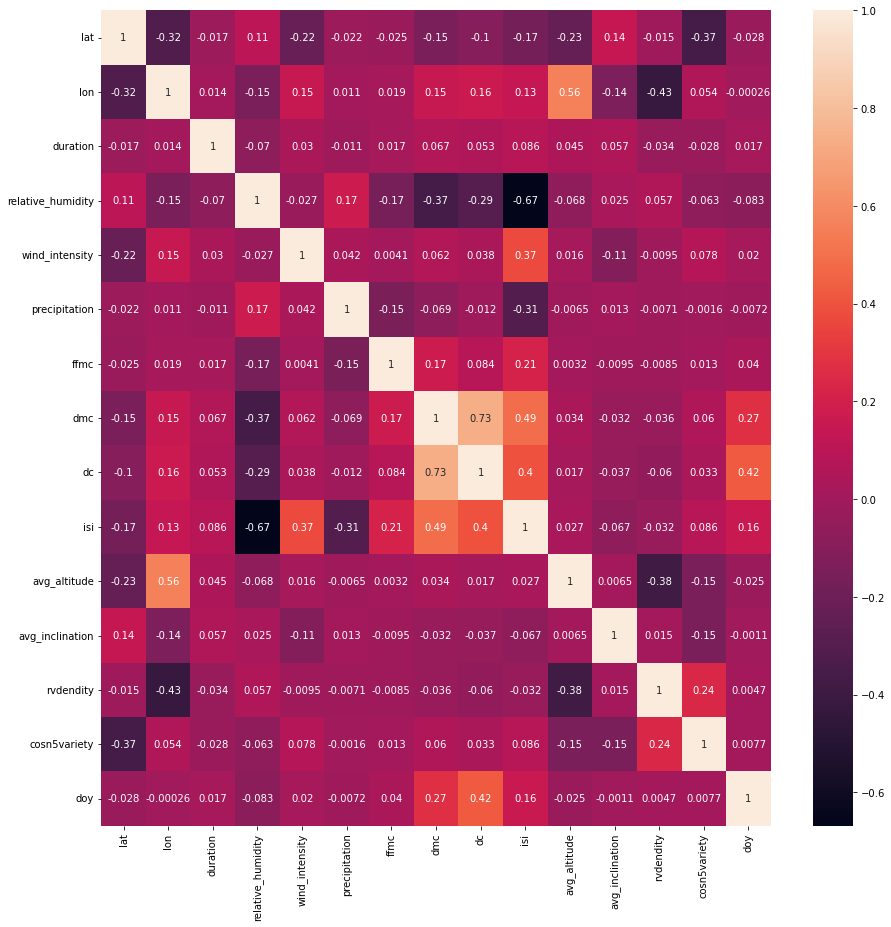

In [12]:
plt.figure(figsize = (len(X_train_num.columns),len(X_train_num.columns)))
correlations_matrix = X_train_num.corr()

sns.heatmap(correlations_matrix, annot=True)

In [13]:
def cat_encode(data, _onehotencoder):
    # one hot encoding all the columns to be one hot encoded
    encoded = _onehotencoder.transform(data).toarray()
    cols = _onehotencoder.get_feature_names(input_features=data.columns)
    # Returning a complete encoded categorical dataset
    return pd.DataFrame(encoded, columns=cols).reset_index(drop=True)

In [14]:
onehotencoder = OneHotEncoder(drop='first', handle_unknown = 'ignore').fit(X_train_cat)

In [15]:
X_train_cat = cat_encode(X_train_cat, onehotencoder)
X_test_cat = cat_encode(X_test_cat, onehotencoder)

In [16]:
X_train_num= X_train_num.reset_index(drop=True)
X_test_num = X_test_num.reset_index(drop=True)
X_train = pd.concat([X_train_num, X_train_cat], axis = 1)
X_test = pd.concat([X_test_num, X_test_cat], axis = 1)

In [17]:
def plot_predictions(original,predicted):
    
    fig, ax = plt.subplots(1, 2)
    
    print("RED - Real data")
    print("GREEN - Predictid values")

    sns.distplot(original, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2},
                color ="red", ax = ax[0])

    sns.distplot(predicted, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2},
                color ="green", ax = ax[1])
    
    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)
    
    plt.show()
    
    print('Total Burned area real:', sum(np.exp(list(original['area_total']))))
    print('Total Burned area predicted:', sum(np.exp(list(predicted))))
    
    return None

In [18]:
def multi_model(X_train, X_test, y_train, y_test, rnd = 1, itr= 500):
    # Creating the model objects, so we can return a valid model even if only one model is selected

    results = []
    results.append(list(y_test['area_total']))
    mlp = MLPRegressor(random_state=rnd, max_iter=itr)
    rfr = RandomForestRegressor(n_estimators = 1500, n_jobs = -1)
    
    
    # Going through all the required models, fitting and printing results
    mlp.fit(X_train, y_train)
    predictions = mlp.predict(X_test)
    print(' MLP regression Predictions R2 :', round(r2_score(y_test, predictions),2)*100, '|',round(mlp.score(X_train, y_train),2)*100,'  Train Score\n' )
    results.append(predictions)
    plot_predictions(y_test,predictions)
    filename = 'Models\\MLP_finalized_model.sav'
    pickle.dump(mlp, open(filename, 'wb'))

    rfr.fit(X_train, y_train)
    predictions_rfr = rfr.predict(X_test)
    print(' Forest Regressor regression Predictions R2 :', round(r2_score(y_test, predictions),2)*100, '|',round(rfr.score(X_train, y_train),2)*100,'  Train Score\n' )
    results.append(predictions_rfr)
    plot_predictions(y_test,predictions_rfr)
    filename = 'Models\\RFR_finalized_model.sav'
    pickle.dump(rfr, open(filename, 'wb'))
        
    res = pd.DataFrame(results).T
    res.columns = ['Real_Values', 'MLP', 'Forest_Regressor']
    res.to_csv('Models\\Modeling Results')
#         res.columns = ['Real_Values', 'MLP', 'Forest_Regressor']
                   
    return res, mlp, rfr

 MLP regression Predictions R2 : 59.0 | 60.0   Train Score

RED - Real data
GREEN - Predictid values


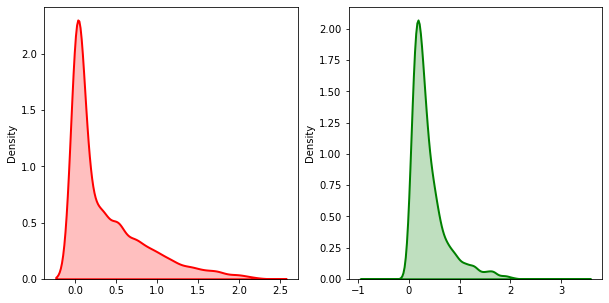

Total Burned area real: 10468.981817985969
Total Burned area predicted: 10143.201468098723
 Forest Regressor regression Predictions R2 : 59.0 | 95.0   Train Score

RED - Real data
GREEN - Predictid values


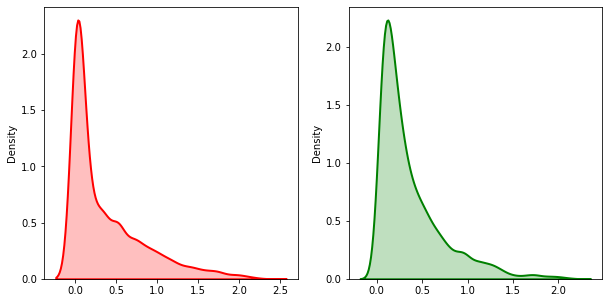

Total Burned area real: 10468.981817985969
Total Burned area predicted: 10002.585366145215


In [19]:
results = multi_model(X_train, X_test, y_train, y_test, 1, 2000)[0]

### Provided function to load a pickled model for furter usage

In [7]:
# Import previously saved model
def import_model(path):
    import pickle
    return pickle.load(open(path, 'rb'))

# Only needed to update the path and reutilize the model
path = 'Models\\RFR_finalized_model.sav'
model = import_model(path)